# IRIS Dataset

In [1]:
# Setup imports
import sklearn
import math
import numpy as np

In [2]:
def get_data(method: str):
    if method not in ["none", "normalise", "standardise"]:
        raise ValueError("Invalid method for data processing")

    # Load dataset
    data = sklearn.datasets.load_iris()

    inputs = data["data"]
    outputs = np.eye(3)[data["target"]]

    # Split dataset, after shuffling. 60% train, 40% test
    np.random.seed(0)
    indices = np.random.permutation(inputs.shape[0])
    inputs = inputs[indices]
    outputs = outputs[indices]

    split = math.floor(inputs.shape[0] * 0.6)
    train_inputs = inputs[:split]
    train_outputs = outputs[:split]
    test_inputs = inputs[split:]
    test_outputs = outputs[split:]

    if method == "none":
        return train_inputs, train_outputs, test_inputs, test_outputs
    
    if method == "normalise":
        mean = np.mean(inputs, axis=0)
        std = np.std(inputs, axis=0)
        train_inputs = (train_inputs - mean) / std
        test_inputs = (test_inputs - mean) / std
        return train_inputs, train_outputs, test_inputs, test_outputs
    
    if method == "standardise":
        min_val = np.min(inputs, axis=0)
        max_val = np.max(inputs, axis=0)
        train_inputs = (train_inputs - min_val) / (max_val - min_val)
        test_inputs = (test_inputs - min_val) / (max_val - min_val)
        return train_inputs, train_outputs, test_inputs, test_outputs
    
    raise ValueError("Invalid method for data processing")

In [3]:
def softmax(values: np.ndarray) -> np.ndarray:
    res = np.exp(values)
    res = res / np.sum(res)
    return res

In [4]:
def predict(inputs: np.ndarray, theta: np.ndarray) -> np.ndarray:
    return softmax(theta @ inputs)

In [5]:
# take a single sample and return outputs for that (4 -> 3 dim)
def cross_entropy_loss(y: np.ndarray, theta: np.ndarray, x: np.ndarray) -> float:
    y_hat = predict(x, theta)
    return -np.sum(y * np.log(y_hat)) 

def cross_entropy_loss_total(y: np.ndarray, theta: np.ndarray, x: np.ndarray) -> float:
    loss = 0
    for i in range(len(y)):
        loss += cross_entropy_loss(y[i], theta, x[i])
    return loss / len(y)

def gradient_cross_entropy(y: np.ndarray, theta: np.ndarray, x: np.ndarray) -> np.ndarray:
    y_hat = predict(x, theta)
    return np.outer(y_hat - y, x)

In [6]:
def gradient_descent(y: np.ndarray, theta: np.ndarray, x: np.ndarray, lr: float, mode: str) -> np.ndarray:
    if len(y) != len(x):
        raise ValueError("y and x must have the same length")
    
    if mode != "sgd" and mode != "gd":
        raise ValueError("Mode must be 'sgd' or 'gd'")
 

    if mode == "gd":
        gradient = np.zeros(theta.shape)
        for j in range(len(y)):
            gradient += gradient_cross_entropy(y[j], theta, x[j])
        
        return theta - lr * (gradient / len(y))
    
    elif mode == "sgd":
        for j in range(len(y)):
            gradient = gradient_cross_entropy(y[j], theta, x[j])
            theta = theta - lr * gradient
        return theta
    
    raise ValueError("Invalid mode")

### Evaluate Model

In [7]:
import sklearn.metrics
import warnings

warnings.filterwarnings("ignore")

def evaluate_model(theta: np.ndarray, inputs: np.ndarray, outputs: np.ndarray) -> dict:
    preds = [np.argmax(predict(x, theta)) for x in inputs]
    outs = [np.argmax(y) for y in outputs]
    f1 = sklearn.metrics.f1_score(outs, preds, average="weighted")
    acc = sklearn.metrics.accuracy_score(outs, preds)
    precision = sklearn.metrics.precision_score(outs, preds, average="weighted")
    recall = sklearn.metrics.recall_score(outs, preds, average="weighted")

    return {
        "f1": f1,
        "accuracy": acc,
        "precision": precision,
        "recall": recall
    }

def get_accuracy(theta: np.ndarray, inputs: np.ndarray, outputs: np.ndarray) -> float:
    preds = [np.argmax(predict(x, theta)) for x in inputs]
    outs = [np.argmax(y) for y in outputs]
    return sklearn.metrics.accuracy_score(outs, preds)


In [8]:
def train_model(lr=0.015, converge_at=10e-5, mode="sgd", preprocessing_method="none") -> tuple[np.ndarray, list, list]:  
    theta = np.zeros((3, 4))
    train_inputs, train_outputs, test_inputs, test_outputs = get_data(preprocessing_method)
    curr_loss = cross_entropy_loss_total(train_outputs, theta, train_inputs)
    i = 0

    losses = []
    accuracies = []

    accuracy = get_accuracy(theta, test_inputs, test_outputs)

    losses.append(curr_loss)
    accuracies.append(accuracy)

    while True:
        theta = gradient_descent(train_outputs, theta, train_inputs, lr, mode)
        new_loss = cross_entropy_loss_total(train_outputs, theta, train_inputs)
        i += 1

        losses.append(new_loss)
        accuracy = get_accuracy(theta, test_inputs, test_outputs)
        accuracies.append(accuracy)

        if np.abs(curr_loss - new_loss) < converge_at:
            break
        curr_loss = new_loss

    evaluation = evaluate_model(theta, test_inputs, test_outputs)

    start = f"[{mode}, {preprocessing_method}]:".ljust(20, " ")

    print(
        f"{start} F1: {round(evaluation['f1'], 2)}, Accuracy: {round(evaluation['accuracy'], 2)}, Precision: {round(evaluation['precision'], 2)}, Recall: {round(evaluation['recall'], 2)}"
    )

    return theta, accuracies, losses

[sgd, none]:         F1: 0.95, Accuracy: 0.95, Precision: 0.95, Recall: 0.95
[sgd, normalise]:    F1: 0.91, Accuracy: 0.92, Precision: 0.93, Recall: 0.92
[sgd, standardise]:  F1: 0.85, Accuracy: 0.85, Precision: 0.85, Recall: 0.85
[gd, none]:          F1: 0.93, Accuracy: 0.93, Precision: 0.93, Recall: 0.93
[gd, normalise]:     F1: 0.91, Accuracy: 0.92, Precision: 0.93, Recall: 0.92
[gd, standardise]:   F1: 0.75, Accuracy: 0.77, Precision: 0.78, Recall: 0.77


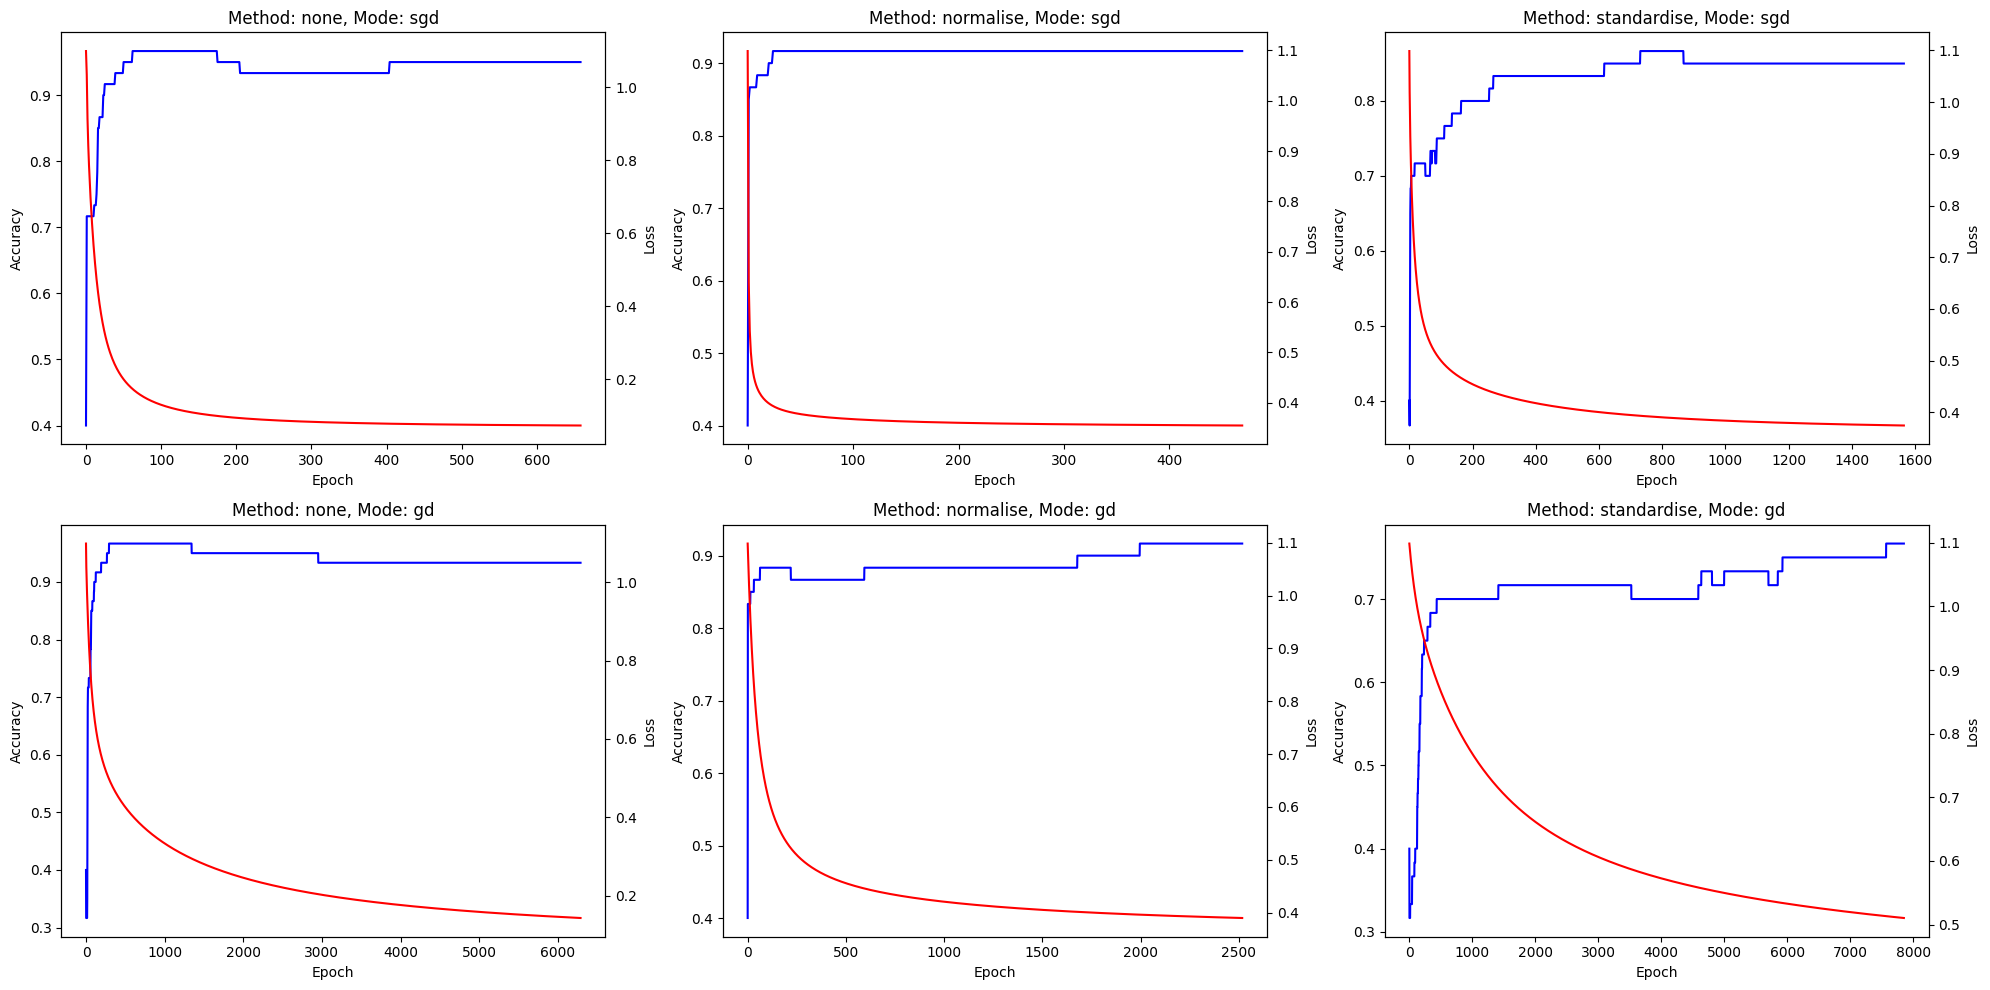

In [9]:
import matplotlib.pyplot as plt

rows = 2
cols = 3

fig, axs = plt.subplots(rows, cols, figsize=(20, 10))

for i, mode in enumerate(["sgd", "gd"]):
    for j, method in enumerate(["none", "normalise", "standardise"]):
        theta, accuracies, losses = train_model(preprocessing_method=method, mode=mode, converge_at=10e-6)

        axs[i, j].set_title(f"Method: {method}, Mode: {mode}")
        axs[i, j].set_xlabel("Epoch")

        axs[i, j].plot(accuracies, label="Accuracy", color="blue")
        axs[i, j].set_ylabel("Accuracy")
        axs[i, j].tick_params(axis="y")

        other_axis = axs[i, j].twinx()
        other_axis.set_ylabel("Loss")
        other_axis.tick_params(axis="y")
        other_axis.plot(losses, label="Loss", color="red")

plt.tight_layout()
plt.show()